# Group 5 notebook

In [2]:
import traci
import os
import sys
import csv
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import keyboard
import time
from brain import TrafficBrain
import torch.nn as nn
import torch 
import numpy as np
import torch.optim as optim

# Group 5 notebook

## Anna Desfourneaux & Quentin Thibault

In [4]:
from run_comparison import run_simulation

In [5]:
# Set SUMO_HOME environment variable
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

In [6]:
SELECTED_TLS = ["B4","C4","D4","E4"]

In [7]:
lanes_to_plot_B4 = ["A4B4_0","A4B4_1","A4B4_2","C4B4_0","C4B4_1","C4B4_2","B5B4_0","B5B4_1","B5B4_2","B3B4_0","B3B4_1","B3B4_2"]
lanes_to_plot_C4 = ["B4C4_0","B4C4_1","B4C4_2","D4C4_0","D4C4_1","D4C4_2","C5C4_0","C5C4_1","C5C4_2","C3C4_0","C3C4_1","C3C4_2"]
lanes_to_plot_D4 = ["C4D4_0","C4D4_1","C4D4_2","E4D4_0","E4D4_1","E4D4_2","D5D4_0","D5D4_1","D5D4_2","D3D4_0","D3D4_1","D3D4_2"]
lanes_to_plot_E4 = ["D4E4_0","D4E4_1","D4E4_2","F4E4_0","F4E4_1","F4E4_2","E5E4_0","E5E4_1","E5E4_2","E3E4_0","E3E4_1","E3E4_2"]

In [8]:
lanes_to_plot = {"B4" : lanes_to_plot_B4, "C4" : lanes_to_plot_C4, "D4" : lanes_to_plot_D4, "E4" : lanes_to_plot_E4}

## Group function

In [9]:
def get_state(tls_id):
    controlled_links = traci.trafficlight.getControlledLinks(tls_id)

    incoming_edges = set(
        link[0].rsplit("_", 1)[0]
        for links in controlled_links
        for link in links
    )

    queues = [
        traci.edge.getLastStepHaltingNumber(edge)
        for edge in incoming_edges
    ]

    while len(queues) < 4:
        queues.append(0)

    queues = queues[:4]
    return torch.FloatTensor([q / 50 for q in queues])



def set_safe_phase(tls_id, target_phase):
    current_phase = traci.trafficlight.getPhase(tls_id)

    if current_phase == target_phase:
        return

    if target_phase == 0:
        yellow_phase = 3
    else:
        yellow_phase = 1

    traci.trafficlight.setPhase(tls_id, yellow_phase)

    for _ in range(YELLOW_DURATION):
        traci.simulationStep()

    traci.trafficlight.setPhase(tls_id, target_phase)

In [10]:
def groupe5(mode, brains, tls_ids):
    
    for tls_id in tls_ids:
        target_phase = None

        # ---------- DECISION ----------
        if mode == "AI":
            state = get_state(tls_id)
            with torch.no_grad():
                probs = brains[tls_id](state)
                action = torch.argmax(probs).item()
            target_phase = 0 if action == 0 else 2

        elif mode == "MaxPressure":
            target_phase = get_max_pressure_action(tls_id)

        else:
            continue

        # ---------- ACTION ----------
        if target_phase is not None:
            set_safe_phase(tls_id, target_phase)

    # ---------- ADVANCE TIME ----------
    traci.simulationStep()

## Training

In [11]:
# --- SETTINGS ---
EPISODES = 1000
STEPS_PER_EPISODE = 1000
CSV_FILE = "training_log.csv"
MODEL_DIR = "models"
YELLOW_DURATION = 3

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


SELECTED_TLS = ["B4","C4","D4","E4"]

# Initialize CSV
with open(CSV_FILE, "w", newline="") as f:
    csv.writer(f).writerow(["episode", "avg_waiting_time", "total_reward"])

# Setup AI
brain = TrafficBrain()
optimizer = optim.Adam(brain.parameters(), lr=0.001)

print("Starting Training...")

# ================= TRAINING LOOP =================
for episode in range(1, EPISODES + 1):
    traci.start(["sumo", "-c", "ff_heterogeneous.sumocfg"])

    total_reward = 0
    total_waiting_time = 0
    step = 0

    while step < STEPS_PER_EPISODE:

        for tls_id in SELECTED_TLS:

            # A. OBSERVE
            state = get_state(tls_id)

            # B. THINK & ACT
            probs = brain(state)
            action = torch.multinomial(probs, 1).item()

            target_phase = 0 if action == 0 else 2
            set_safe_phase(tls_id, target_phase)

        # avancer la simulation (1 pas vert)
        traci.simulationStep()
        step += 1 + YELLOW_DURATION

        # C. REWARD (somme sur les 4 intersections)
        waiting = 0
        for tls_id in SELECTED_TLS:
            edges = {
                link[0].rsplit("_", 1)[0]
                for links in traci.trafficlight.getControlledLinks(tls_id)
                for link in links
            }
            waiting += sum(
                traci.edge.getLastStepHaltingNumber(e) for e in edges
            )

        reward = -waiting
        total_reward += reward
        total_waiting_time += waiting

        # D. LEARN
        loss = -torch.log(probs[action]) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    traci.close()

    avg_wait = total_waiting_time / step
    print(f"Episode {episode}: Avg Wait={avg_wait:.2f}s | Total Reward={total_reward}")

    with open(CSV_FILE, "a", newline="") as f:
        csv.writer(f).writerow([episode, avg_wait, total_reward])

    if episode % 5 == 0:
        brain.save(f"{MODEL_DIR}/policy_ep{episode}.pth")

print("Done.")

Starting Training...
Episode 1: Avg Wait=18.33s | Total Reward=-18329


KeyboardInterrupt: 

## Run simulations - every intersections are considered

In [12]:
def get_state(tls_id):
    controlled_links = traci.trafficlight.getControlledLinks(tls_id)

    incoming_edges = set(
        link[0].rsplit("_", 1)[0]
        for links in controlled_links
        for link in links
    )

    state = [
        traci.edge.getLastStepHaltingNumber(edge)
        for edge in sorted(incoming_edges)
    ]

    if len(state) < 4:
        state += [0] * (4 - len(state))

    return np.array(state[:4])

In [13]:
def set_safe_phase(tls_id, target_phase):
    current_phase = traci.trafficlight.getPhase(tls_id)
    if current_phase == target_phase:
        return

    if target_phase == 0:
        yellow_phase = 3
    else:
        yellow_phase = 1

    traci.trafficlight.setPhase(tls_id, yellow_phase)

    for _ in range(YELLOW_DURATION): #lui
        traci.simulationStep() #lui

    traci.trafficlight.setPhase(tls_id, target_phase)

In [14]:
def get_max_pressure_action(tls_id):
    controlled_links = traci.trafficlight.getControlledLinks(tls_id)

    in_edges = set()
    out_edges = set()

    for links in controlled_links:
        for link in links:
            in_edges.add(link[0].rsplit("_", 1)[0])
            out_edges.add(link[1].rsplit("_", 1)[0])

    incoming = sum(traci.edge.getLastStepHaltingNumber(e) for e in in_edges)
    outgoing = sum(traci.edge.getLastStepVehicleNumber(e) for e in out_edges)


    return 0 if incoming - outgoing > 0 else 2


In [15]:
MODEL_PATH = "models/1policy_ep300.pth"
YELLOW_DURATION = 3
SIM_DURATION = 3000


def get_state(tls_id):
    controlled_links = traci.trafficlight.getControlledLinks(tls_id)

    incoming_edges = set(
        link[0].rsplit("_", 1)[0]
        for links in controlled_links
        for link in links
    )

    queues = [
        traci.edge.getLastStepHaltingNumber(edge)
        for edge in incoming_edges
    ]

    while len(queues) < 4:
        queues.append(0)

    queues = queues[:4]
    return torch.FloatTensor([q / 50 for q in queues])



def set_safe_phase(tls_id, target_phase):
    current_phase = traci.trafficlight.getPhase(tls_id)
    if current_phase == target_phase:
        return

    if target_phase == 0:
        yellow_phase = 3
    else:
        yellow_phase = 1

    traci.trafficlight.setPhase(tls_id, yellow_phase)

    for _ in range(YELLOW_DURATION): #lui
        traci.simulationStep() #lui

    traci.trafficlight.setPhase(tls_id, target_phase)



def get_max_pressure_action(tls_id):
    controlled_links = traci.trafficlight.getControlledLinks(tls_id)

    in_edges = set()
    out_edges = set()

    for links in controlled_links:
        for link in links:
            in_edges.add(link[0].rsplit("_", 1)[0])
            out_edges.add(link[1].rsplit("_", 1)[0])

    incoming = sum(traci.edge.getLastStepHaltingNumber(e) for e in in_edges)
    outgoing = sum(traci.edge.getLastStepVehicleNumber(e) for e in out_edges)


    return 0 if incoming - outgoing > 0 else 2


# ================= SIMULATION RUNNER =================
def run_simulation(mode="AI", output_file="tripinfo_ai.xml"):
    print(f"Running Simulation in {mode} mode...")

    sumo_cmd = [
        "sumo-gui",
        "-c", "ff_heterogeneous.sumocfg",
        "--tripinfo-output", output_file
    ]
    traci.start(sumo_cmd)

    brain = None
    if mode == "AI":
        brain = TrafficBrain()
        if os.path.exists(MODEL_PATH):
            brain.load(MODEL_PATH)
            brain.eval()
        else:
            print("ERROR: Model not found!")
            traci.close()
            sys.exit()

    while traci.simulation.getTime() < SIM_DURATION:

        groupe5(mode, brains, SELECTED_TLS)

        traci.simulationStep()

    traci.close()
    print(f"Finished {mode}. Saved to {output_file}")


# ================= MAIN =================
if __name__ == "__main__":
    run_simulation(mode="Normal", output_file="tripinfo_normal.xml")
    run_simulation(mode="MaxPressure", output_file="tripinfo_maxpressure.xml")
    run_simulation(mode="AI", output_file="tripinfo_ai.xml")
    print("\n✅ Done!")

Running Simulation in Normal mode...


TraCIException: Connection 'default' is already active.

## New training : using AI for each intersection separately

In [ ]:
# --- SETTINGS ---
EPISODES = 300
STEPS_PER_EPISODE = 1000
CSV_FILE = "training_log_B4.csv"
MODEL_DIR = "models"
YELLOW_DURATION = 3

if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

# Initialize CSV
with open(CSV_FILE, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["episode", "avg_waiting_time", "total_reward"])

# Helper: Normalize Queue Lengths
def get_state():
    q_n = traci.edge.getLastStepHaltingNumber("B5B4")
    q_s = traci.edge.getLastStepHaltingNumber("B3B4")
    q_e = traci.edge.getLastStepHaltingNumber("C4B4")
    q_w = traci.edge.getLastStepHaltingNumber("A4B4")
    return torch.FloatTensor([q_n/50, q_s/50, q_e/50, q_w/50])

# --- SAFETY LOGIC FUNCTION ---
def set_safe_phase(target_phase):
    """
    Switches traffic light safely.
    If we are Green on NS and want to go Green EW, we MUST show Yellow first.
    SUMO Phases (Standard Guess):
    0: NS Green (GrGr)
    1: NS Yellow (yryr)
    2: EW Green (rGrG)
    3: EW Yellow (ryry)
    """
    current_phase = traci.trafficlight.getPhase("B4")
    
    # If we are already in the target phase, do nothing
    if current_phase == target_phase:
        return

    yellow_phase = current_phase + 1
    
    # 1. Switch to Yellow
    traci.trafficlight.setPhase("B4", yellow_phase)
    
    # 2. Hold Yellow for 3 seconds (simulate 3 steps)
    for _ in range(YELLOW_DURATION):
        traci.simulationStep()
        
    # 3. Finally switch to the new Green target
    traci.trafficlight.setPhase("B4", target_phase)


# Setup AI
brain = TrafficBrain()
optimizer = optim.Adam(brain.parameters(), lr=0.001)

# --- TRAINING LOOP ---
print(f"Starting Training...")

for episode in range(1, EPISODES + 1):
    traci.start(["sumo", "-c", "ff_heterogeneous.sumocfg"])
    
    total_reward = 0
    total_waiting_time = 0
    step = 0
    
    while step < STEPS_PER_EPISODE:
        # A. OBSERVE
        state = get_state()
        
        # B. THINK & ACT
        probs = brain(state)
        action = torch.multinomial(probs, 1).item()
        

        target_phase = 0 if action == 0 else 2
        
        # Use our safe switcher
        set_safe_phase(target_phase)
        
        # Run 1 step of Green
        traci.simulationStep()
        step += 1 + YELLOW_DURATION
        
        # C. REWARD
        waiting = (traci.edge.getLastStepHaltingNumber("B5B4") + 
                   traci.edge.getLastStepHaltingNumber("B3B4") + 
                   traci.edge.getLastStepHaltingNumber("C4B4") + 
                   traci.edge.getLastStepHaltingNumber("A4B4"))
                
        reward = -waiting
        total_reward += reward
        total_waiting_time += waiting
        
        # D. LEARN
        loss = -torch.log(probs[action]) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    traci.close()
    
    avg_wait = total_waiting_time / step
    print(f"Episode {episode}: Avg Wait={avg_wait:.2f}s | Total Reward={total_reward}")
    
    with open(CSV_FILE, "a", newline="") as f:
        csv.writer(f).writerow([episode, avg_wait, total_reward])
        
    if episode % 5 == 0:
        brain.save(f"{MODEL_DIR}/policy_ep{episode}.pth")

print("Done.")

In [ ]:
# --- SETTINGS ---
EPISODES = 300
STEPS_PER_EPISODE = 1000
CSV_FILE = "training_log_C4.csv"
MODEL_DIR = "models"
YELLOW_DURATION = 3

if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

# Initialize CSV
with open(CSV_FILE, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["episode", "avg_waiting_time", "total_reward"])

# Helper: Normalize Queue Lengths
def get_state():
    q_n = traci.edge.getLastStepHaltingNumber("C5C4")
    q_s = traci.edge.getLastStepHaltingNumber("C3C4")
    q_e = traci.edge.getLastStepHaltingNumber("D4C4")
    q_w = traci.edge.getLastStepHaltingNumber("B4C4")
    return torch.FloatTensor([q_n/50, q_s/50, q_e/50, q_w/50])

# --- SAFETY LOGIC FUNCTION ---
def set_safe_phase(target_phase):
    """
    Switches traffic light safely.
    If we are Green on NS and want to go Green EW, we MUST show Yellow first.
    SUMO Phases (Standard Guess):
    0: NS Green (GrGr)
    1: NS Yellow (yryr)
    2: EW Green (rGrG)
    3: EW Yellow (ryry)
    """
    current_phase = traci.trafficlight.getPhase("C4")
    
    if current_phase == target_phase:
        return

    yellow_phase = current_phase + 1
    
    # 1. Switch to Yellow
    traci.trafficlight.setPhase("C4", yellow_phase)
    
    # 2. Hold Yellow for 3 seconds
    for _ in range(YELLOW_DURATION):
        traci.simulationStep()
        
    # 3. Finally switch to the new Green target
    traci.trafficlight.setPhase("C4", target_phase)


# Setup AI
brain = TrafficBrain()
optimizer = optim.Adam(brain.parameters(), lr=0.001)

# --- TRAINING LOOP ---
print(f"Starting Training...")

for episode in range(1, EPISODES + 1):
    traci.start(["sumo", "-c", "ff_heterogeneous.sumocfg"])
    
    total_reward = 0
    total_waiting_time = 0
    step = 0
    
    while step < STEPS_PER_EPISODE:
        # A. OBSERVE
        state = get_state()
        
        # B. THINK & ACT
        probs = brain(state)
        action = torch.multinomial(probs, 1).item()
        
        # Action 0 = NS Green (Phase 0), Action 1 = EW Green (Phase 2)
        target_phase = 0 if action == 0 else 2
        
        # Use our safe switcher
        set_safe_phase(target_phase)
        
        # Run 1 step of Green
        traci.simulationStep()
        step += 1 + YELLOW_DURATION
        
        # C. REWARD
        waiting = (traci.edge.getLastStepHaltingNumber("C5C4") + 
                   traci.edge.getLastStepHaltingNumber("C3C4") + 
                   traci.edge.getLastStepHaltingNumber("D4C4") + 
                   traci.edge.getLastStepHaltingNumber("B4C4"))
                
        reward = -waiting
        total_reward += reward
        total_waiting_time += waiting
        
        # D. LEARN
        loss = -torch.log(probs[action]) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    traci.close()
    
    avg_wait = total_waiting_time / step
    print(f"Episode {episode}: Avg Wait={avg_wait:.2f}s | Total Reward={total_reward}")
    
    with open(CSV_FILE, "a", newline="") as f:
        csv.writer(f).writerow([episode, avg_wait, total_reward])
        
    if episode % 5 == 0:
        brain.save(f"{MODEL_DIR}/policy_ep{episode}.pth")

print("Done.")

In [ ]:
# --- SETTINGS ---
EPISODES = 300
STEPS_PER_EPISODE = 1000
CSV_FILE = "training_log_D4.csv"
MODEL_DIR = "models"
YELLOW_DURATION = 3

if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

# Initialize CSV
with open(CSV_FILE, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["episode", "avg_waiting_time", "total_reward"])

# Helper: Normalize Queue Lengths
def get_state():
    q_n = traci.edge.getLastStepHaltingNumber("D5D4")
    q_s = traci.edge.getLastStepHaltingNumber("D3D4")
    q_e = traci.edge.getLastStepHaltingNumber("E4D4")
    q_w = traci.edge.getLastStepHaltingNumber("C4D4")
    return torch.FloatTensor([q_n/50, q_s/50, q_e/50, q_w/50])

# --- SAFETY LOGIC FUNCTION ---
def set_safe_phase(target_phase):
    """
    Switches traffic light safely.
    If we are Green on NS and want to go Green EW, we MUST show Yellow first.
    SUMO Phases (Standard Guess):
    0: NS Green (GrGr)
    1: NS Yellow (yryr)
    2: EW Green (rGrG)
    3: EW Yellow (ryry)
    """
    current_phase = traci.trafficlight.getPhase("D4")
    
    if current_phase == target_phase:
        return

    yellow_phase = current_phase + 1
    
    # 1. Switch to Yellow
    traci.trafficlight.setPhase("D4", yellow_phase)
    
    # 2. Hold Yellow for 3 seconds
    for _ in range(YELLOW_DURATION):
        traci.simulationStep()
        
    # 3. Finally switch to the new Green target
    traci.trafficlight.setPhase("D4", target_phase)


# Setup AI
brain = TrafficBrain()
optimizer = optim.Adam(brain.parameters(), lr=0.001)

# --- TRAINING LOOP ---
print(f"Starting Training...")

for episode in range(1, EPISODES + 1):
    traci.start(["sumo", "-c", "ff_heterogeneous.sumocfg"])
    
    total_reward = 0
    total_waiting_time = 0
    step = 0
    
    while step < STEPS_PER_EPISODE:
        # A. OBSERVE
        state = get_state()
        
        # B. THINK & ACT
        probs = brain(state)
        action = torch.multinomial(probs, 1).item()
        
        # Action 0 = NS Green (Phase 0), Action 1 = EW Green (Phase 2)
        target_phase = 0 if action == 0 else 2
        
        # Use our safe switcher
        set_safe_phase(target_phase)
        
        # Run 1 step of Green
        traci.simulationStep()
        step += 1 + YELLOW_DURATION
        
        # C. REWARD
        waiting = (traci.edge.getLastStepHaltingNumber("D5D4") + 
                   traci.edge.getLastStepHaltingNumber("D3D4") + 
                   traci.edge.getLastStepHaltingNumber("E4D4") + 
                   traci.edge.getLastStepHaltingNumber("C4D4"))
                
        reward = -waiting
        total_reward += reward
        total_waiting_time += waiting
        
        # D. LEARN
        loss = -torch.log(probs[action]) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    traci.close()
    
    avg_wait = total_waiting_time / step
    print(f"Episode {episode}: Avg Wait={avg_wait:.2f}s | Total Reward={total_reward}")
    
    with open(CSV_FILE, "a", newline="") as f:
        csv.writer(f).writerow([episode, avg_wait, total_reward])
        
    if episode % 5 == 0:
        brain.save(f"{MODEL_DIR}/policy_ep{episode}.pth")

print("Done.")

In [ ]:
# --- SETTINGS ---
EPISODES = 300
STEPS_PER_EPISODE = 1000
CSV_FILE = "training_log_E4.csv"
MODEL_DIR = "models"
YELLOW_DURATION = 3

if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

# Initialize CSV
with open(CSV_FILE, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["episode", "avg_waiting_time", "total_reward"])

# Helper: Normalize Queue Lengths
def get_state():
    q_n = traci.edge.getLastStepHaltingNumber("E5E4")
    q_s = traci.edge.getLastStepHaltingNumber("E3E4")
    q_e = traci.edge.getLastStepHaltingNumber("F4E4")
    q_w = traci.edge.getLastStepHaltingNumber("D4E4")
    return torch.FloatTensor([q_n/50, q_s/50, q_e/50, q_w/50])

# --- SAFETY LOGIC FUNCTION ---
def set_safe_phase(target_phase):
    """
    Switches traffic light safely.
    If we are Green on NS and want to go Green EW, we MUST show Yellow first.
    SUMO Phases (Standard Guess):
    0: NS Green (GrGr)
    1: NS Yellow (yryr)
    2: EW Green (rGrG)
    3: EW Yellow (ryry)
    """
    current_phase = traci.trafficlight.getPhase("E4")
    
    if current_phase == target_phase:
        return

    yellow_phase = current_phase + 1
    
    # 1. Switch to Yellow
    traci.trafficlight.setPhase("E4", yellow_phase)
    
    # 2. Hold Yellow for 3 seconds
    for _ in range(YELLOW_DURATION):
        traci.simulationStep()
        
    # 3. Finally switch to the new Green target
    traci.trafficlight.setPhase("E4", target_phase)


# Setup AI
brain = TrafficBrain()
optimizer = optim.Adam(brain.parameters(), lr=0.001)

# --- TRAINING LOOP ---
print(f"Starting Training...")

for episode in range(1, EPISODES + 1):
    traci.start(["sumo", "-c", "ff_heterogeneous.sumocfg"])
    
    total_reward = 0
    total_waiting_time = 0
    step = 0
    
    while step < STEPS_PER_EPISODE:
        # A. OBSERVE
        state = get_state()
        
        # B. THINK & ACT
        probs = brain(state)
        action = torch.multinomial(probs, 1).item()
        
        # Action 0 = NS Green (Phase 0), Action 1 = EW Green (Phase 2)
        target_phase = 0 if action == 0 else 2
        
        # Use our safe switcher
        set_safe_phase(target_phase)
        
        # Run 1 step of Green
        traci.simulationStep()
        step += 1 + YELLOW_DURATION
        
        # C. REWARD
        waiting = (traci.edge.getLastStepHaltingNumber("E5E4") + 
                   traci.edge.getLastStepHaltingNumber("E3E4") + 
                   traci.edge.getLastStepHaltingNumber("F4E4") + 
                   traci.edge.getLastStepHaltingNumber("D4E4"))
                
        reward = -waiting
        total_reward += reward
        total_waiting_time += waiting
        
        # D. LEARN
        loss = -torch.log(probs[action]) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    traci.close()
    
    avg_wait = total_waiting_time / step
    print(f"Episode {episode}: Avg Wait={avg_wait:.2f}s | Total Reward={total_reward}")
    
    with open(CSV_FILE, "a", newline="") as f:
        csv.writer(f).writerow([episode, avg_wait, total_reward])
        
    if episode % 5 == 0:
        brain.save(f"{MODEL_DIR}/policy_ep{episode}.pth")

print("Done.")

## Run simulation : using AI for each intersection separately

In [ ]:
SELECTED_TLS = ["B4", "C4", "D4", "E4"]

MODEL_PATHS = {
    "B4": "B4policy_ep300.pth",
    "C4": "C4policy_ep300.pth",
    "D4": "D4policy_ep300.pth",
    "E4": "E4policy_ep300.pth"
}

YELLOW_DURATION = 3
SIM_DURATION = 3000


def get_state(tls_id):
    controlled_links = traci.trafficlight.getControlledLinks(tls_id)

    incoming_edges = set(
        link[0].rsplit("_", 1)[0]
        for links in controlled_links
        for link in links
    )

    queues = [traci.edge.getLastStepHaltingNumber(e) for e in incoming_edges]

    while len(queues) < 4:
        queues.append(0)

    queues = queues[:4]
    return torch.FloatTensor([q / 50 for q in queues])


def set_safe_phase(tls_id, target_phase):
    current_phase = traci.trafficlight.getPhase(tls_id)
    if current_phase == target_phase:
        return

    yellow_phase = 3 if target_phase == 0 else 1
    traci.trafficlight.setPhase(tls_id, yellow_phase)

    for _ in range(YELLOW_DURATION):
        traci.simulationStep()

    traci.trafficlight.setPhase(tls_id, target_phase)


def get_max_pressure_action(tls_id):
    controlled_links = traci.trafficlight.getControlledLinks(tls_id)

    in_edges, out_edges = set(), set()
    for links in controlled_links:
        for link in links:
            in_edges.add(link[0].rsplit("_", 1)[0])
            out_edges.add(link[1].rsplit("_", 1)[0])

    incoming = sum(traci.edge.getLastStepHaltingNumber(e) for e in in_edges)
    outgoing = sum(traci.edge.getLastStepVehicleNumber(e) for e in out_edges)

    return 0 if incoming - outgoing > 0 else 2


# ================= SIMULATION RUNNER =================
def run_simulation(mode="AI", output_file="tripinfo_ai.xml", queue_file="queue_ai.xml"):
    print(f"Running Simulation in {mode} mode...")

    traci.start([
        "sumo-gui",
        "-c", "ff_heterogeneous.sumocfg",
        "--tripinfo-output", output_file,
        "--queue-output", queue_file
    ])

    brains = {}

    if mode == "AI":
        for tls_id in SELECTED_TLS:
            model_path = MODEL_PATHS[tls_id]
            if not os.path.exists(model_path):
                print(f"Model missing for {tls_id}")
                traci.close()
                sys.exit()

            brain = TrafficBrain()
            brain.load(model_path)
            brain.eval()
            brains[tls_id] = brain

    while traci.simulation.getTime() < SIM_DURATION:

        groupe5(mode, brains, SELECTED_TLS)

        traci.simulationStep()

    traci.close()
    print(f"Finished {mode}. Saved to {output_file}")


# ================= MAIN =================
if __name__ == "__main__":
    run_simulation("Normal", "tripinfo_normal.xml", "queue_normal.xml")
    run_simulation("MaxPressure", "tripinfo_maxpressure.xml", "queue_maxpressure.xml")
    run_simulation("AI", "tripinfo_ai.xml", "queue_ai.xml")

    print("\n✅ Done!")


## Get infos of the trip file

In [25]:
def tripinfo(file_name):
    tree = ET.parse(file_name)
    root = tree.getroot()

    trip_data = []
    for trip in root.findall('tripinfo'):
        emissions = trip.find('emissions')
        trip_data.append({
            'id': trip.get('id'),
            'vType': trip.get('vType'),
            'duration': float(trip.get('duration')),
            'arrival': float(trip.get('arrival')),
            'waitingTime': float(trip.get('waitingTime')),
            'timeLoss': float(trip.get('timeLoss')),
            'departLane': trip.get('departLane'),
            "CO2": float(emissions.get("CO2_abs")),
            "NOx": float(emissions.get("NOx_abs")),
            "PMx": float(emissions.get("PMx_abs"))
        })
    return trip_data

df_normal = pd.DataFrame(tripinfo("tripinfo_normal.xml"))
df_maxpressure = pd.DataFrame(tripinfo("tripinfo_maxpressure.xml"))
df_ai = pd.DataFrame(tripinfo("tripinfo_ai.xml"))

print(df_normal.head())
print(df_maxpressure.head())
print(df_ai.head())

      id vType  duration  arrival  waitingTime  timeLoss departLane  \
0  f_4.0   bus     127.0    127.0         37.0     55.69     C5C4_0   
1  f_5.0   bus     127.0    127.0         38.0     55.25     C0C1_0   
2  f_4.1   bus     142.0    202.0         44.0     70.30     C5C4_0   
3  f_5.1   bus     142.0    202.0         46.0     70.83     C0C1_0   
4  f_0.0  bike     219.0    220.0         26.0     49.45     D5D4_0   

          CO2     NOx     PMx  
0  1339792.40  624.65  197.46  
1  1316946.84  614.12  194.17  
2  1551294.97  687.47  216.46  
3  1550772.51  688.04  216.57  
4        0.00    0.00    0.00  
      id vType  duration  arrival  waitingTime  timeLoss departLane  \
0  f_5.0   bus     140.0    140.0         42.0     68.62     C0C1_0   
1  f_4.1   bus      80.0    140.0          0.0      8.06     C5C4_0   
2  f_4.0   bus     141.0    141.0         43.0     69.75     C5C4_0   
3  f_5.1   bus     111.0    171.0         13.0     39.12     C0C1_0   
4  f_0.0  bike     220.0  

## Gets infos of the queue file

In [17]:
def queue_data(file_name):
    tree = ET.parse(file_name)
    root = tree.getroot()

    data = []

    for data_elem in root.findall('data'):
        timestep = float(data_elem.get('timestep'))

        lanes = data_elem.find('lanes')
        if lanes is None:
            continue

        for lane in lanes.findall('lane'):
            lane_id = lane.get('id')
            queue_len = lane.get('queueing_length')

            if lane_id is not None and queue_len is not None:
                data.append({
                    'lane_id': lane_id,
                    'timestep': timestep,
                    'queueing_length': float(queue_len.replace(',', '.'))
                })
    return data

df_queue_normal = pd.DataFrame(queue_data('queue_normal.xml'))
df_queue_maxpressure = pd.DataFrame(queue_data('queue_maxpressure.xml'))
df_queue_ai = pd.DataFrame(queue_data('queue_ai.xml'))
print(df_queue_normal.head())
print(df_queue_maxpressure.head())
print(df_queue_ai.head())

  lane_id  timestep  queueing_length
0  D5D4_0      19.0           187.21
1  D0D1_0      29.0           187.20
2  B5B4_0      45.0             0.00
3  D5D4_0      45.0             0.00
4  B5B4_0      46.0             2.61
  lane_id  timestep  queueing_length
0  D5D4_0      19.0           187.21
1  C5C4_0      22.0             0.00
2  C5C4_0      23.0            13.00
3  C5C4_0      24.0            13.00
4  C5C4_0      25.0            13.00
  lane_id  timestep  queueing_length
0  D5D4_0      19.0           187.21
1  D0D1_0      29.0           187.20
2  B5B4_0      45.0             0.00
3  D5D4_0      45.0             0.00
4  B5B4_0      46.0             2.61


## Waiting time

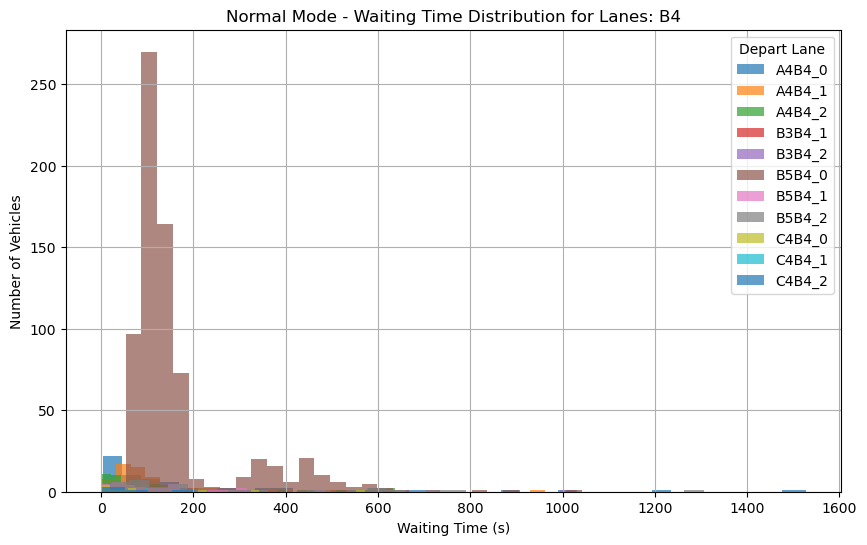

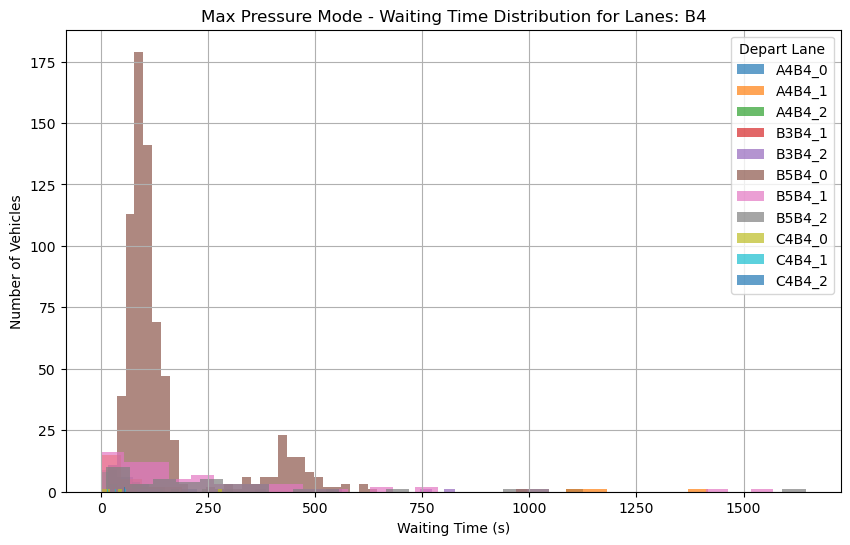

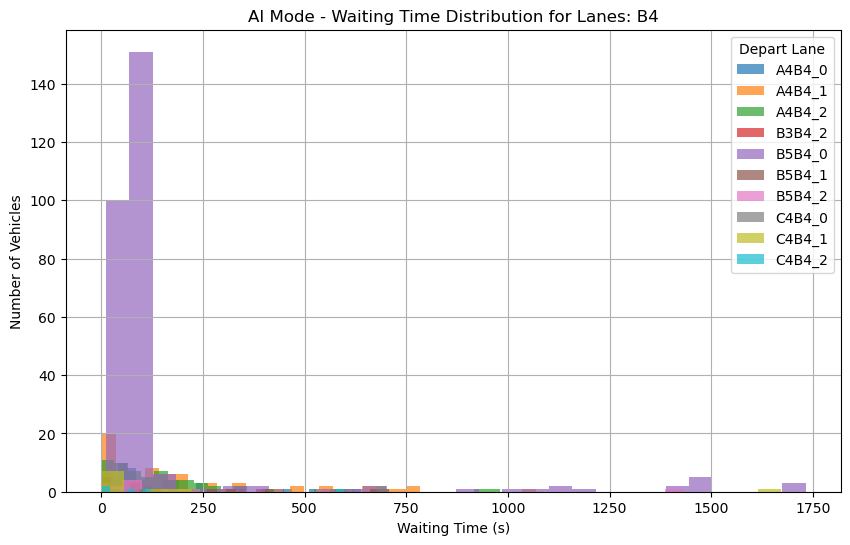

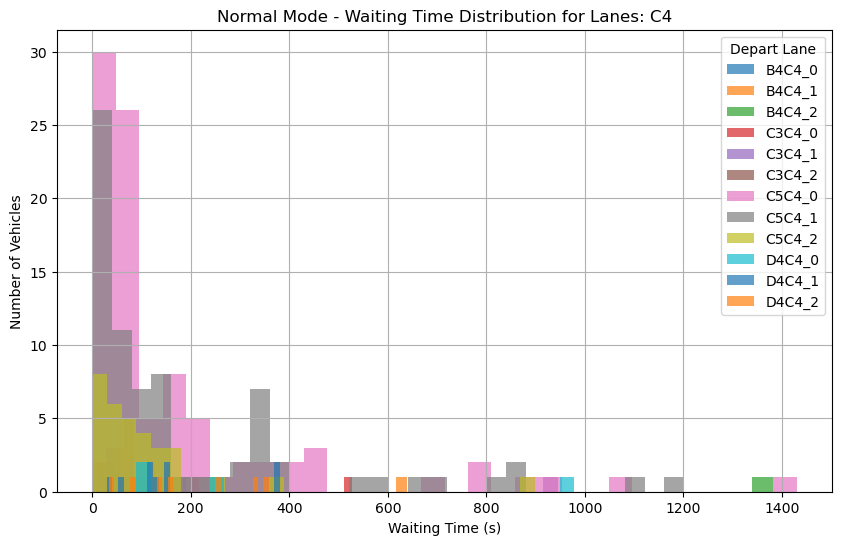

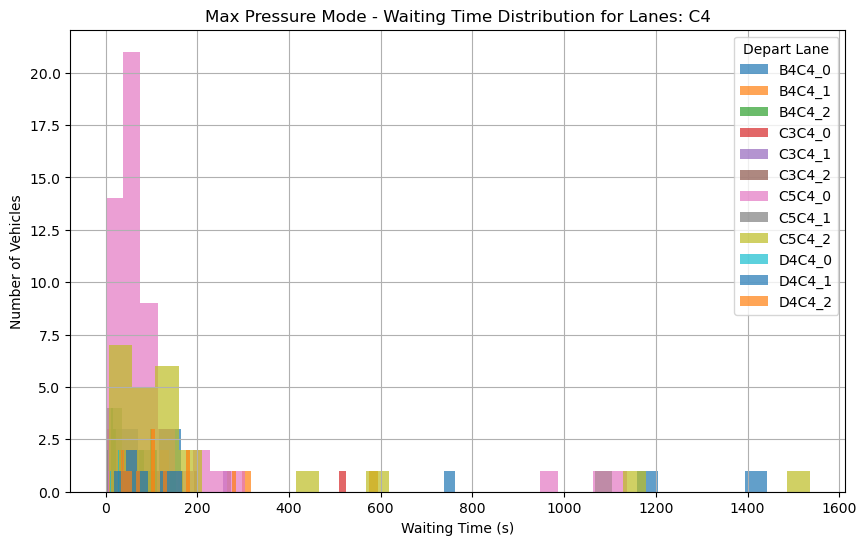

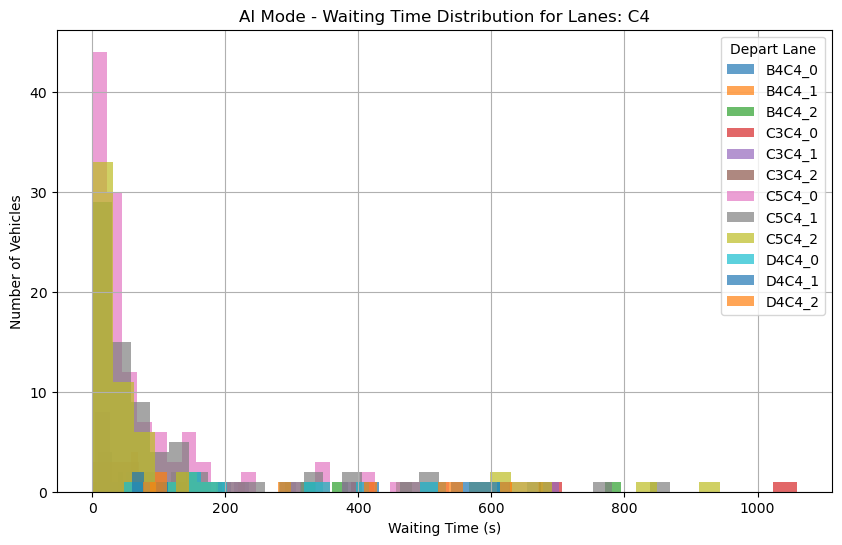

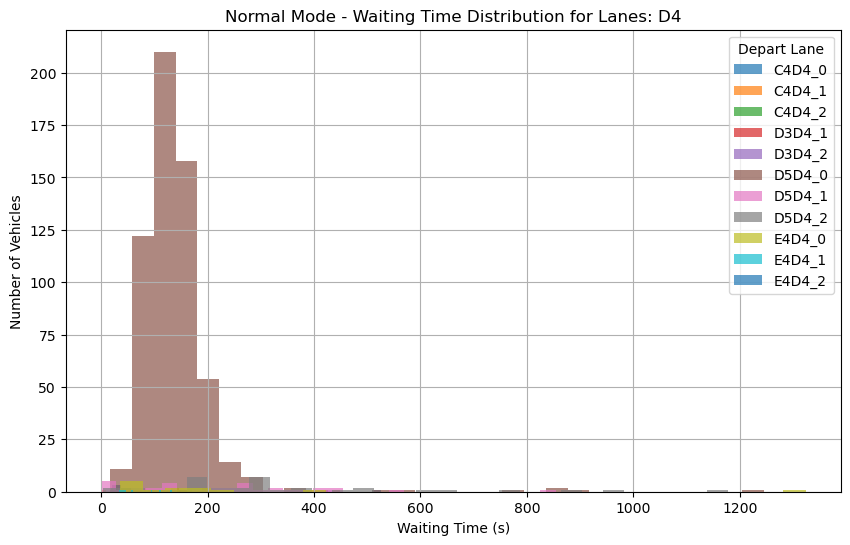

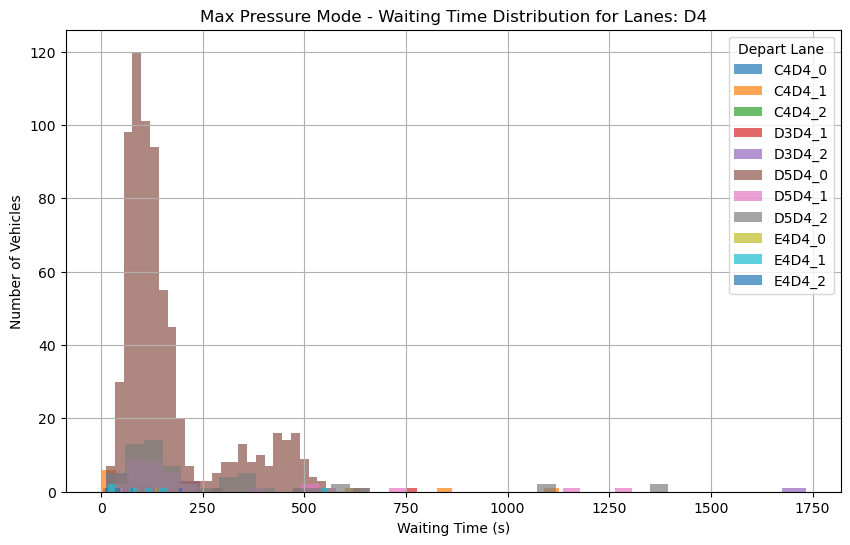

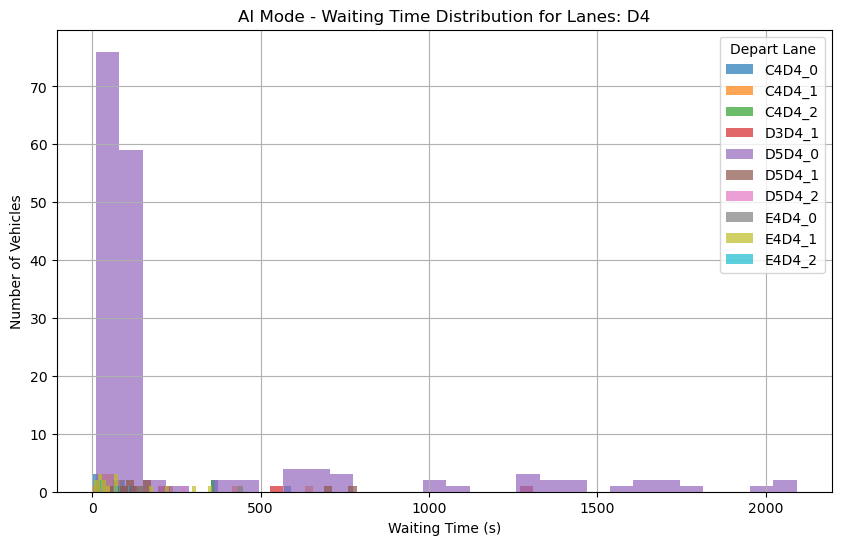

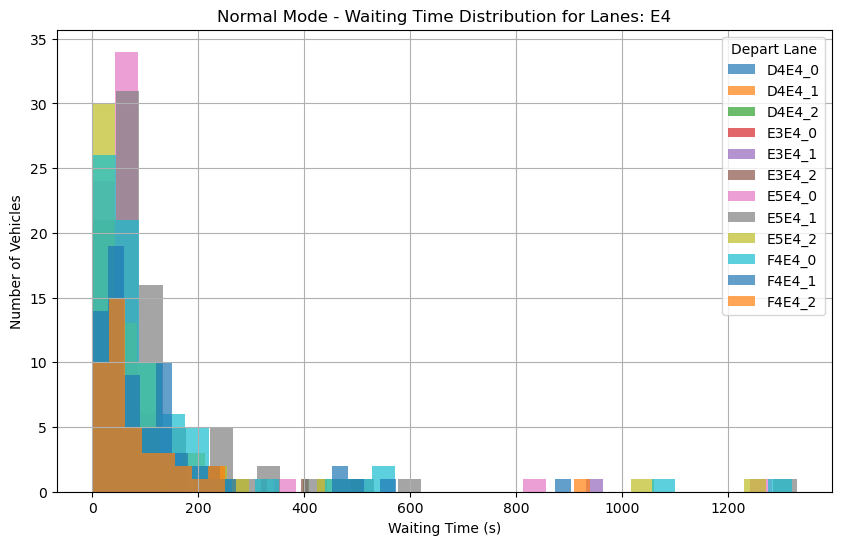

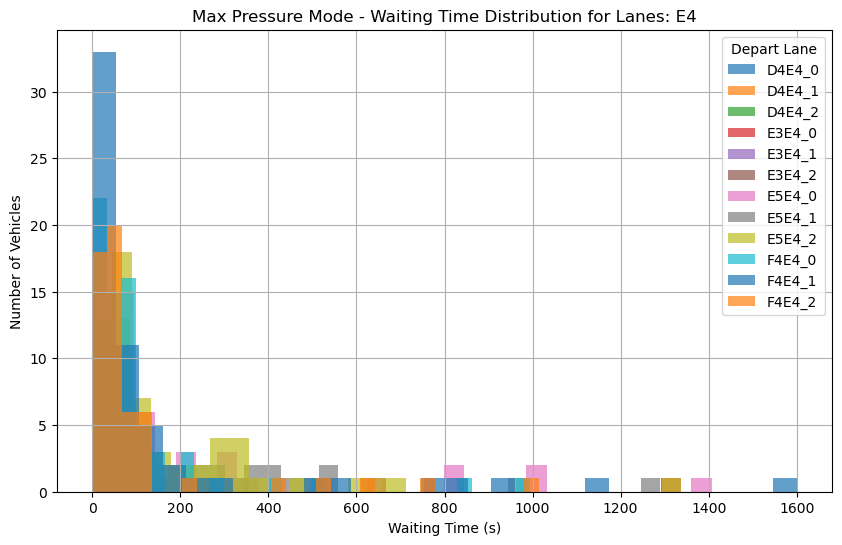

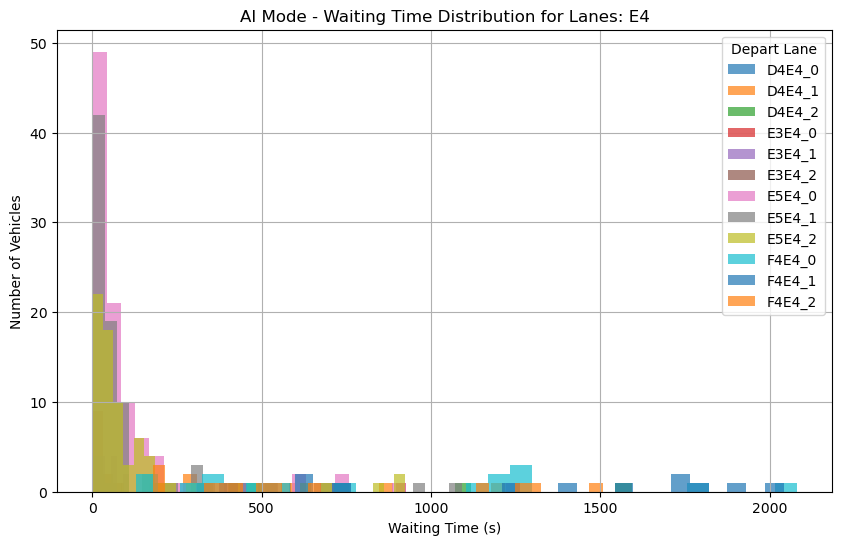

In [18]:
def plot_waiting_time_histogram(df, title, filename,lanes_to_plot):
    df_filtered = df[df['departLane'].isin(lanes_to_plot)]
    plt.figure(figsize=(10, 6))
    for lane, group in df_filtered.groupby('departLane'):
        plt.hist(group['waitingTime'], bins=30, alpha=0.7,label=lane)
    plt.xlabel('Waiting Time (s)')
    plt.ylabel('Number of Vehicles')
    plt.title(title)
    plt.grid(True)
    plt.legend(title="Depart Lane")
    plt.savefig(filename)
    plt.show()

for lane_name, lane_list in lanes_to_plot.items():
    plot_waiting_time_histogram(
        df_normal,
        title=f'Normal Mode - Waiting Time Distribution for Lanes: {lane_name}',
        filename=f'waiting_time_histogram_normal_{lane_name}.png',
        lanes_to_plot=lane_list
    )


    plot_waiting_time_histogram(
        df_maxpressure, 
        title=f'Max Pressure Mode - Waiting Time Distribution for Lanes: {lane_name}', 
        filename=f'waiting_time_histogram_maxpressure_{lane_name}.png', 
        lanes_to_plot=lane_list 
        )


    plot_waiting_time_histogram(
        df_ai, 
        title=f'AI Mode - Waiting Time Distribution for Lanes: {lane_name}',
        filename=f'waiting_time_histogram_ai_{lane_name}.png', 
        lanes_to_plot=lane_list    
        )



In [19]:
def average_waiting_time(df):
    return df['waitingTime'].mean()

for lane_name, lane_list in lanes_to_plot.items():
    avg_wait_normal = average_waiting_time(df_normal[df_normal['departLane'].isin(lane_list)])
    avg_wait_maxpressure = average_waiting_time(df_maxpressure[df_maxpressure['departLane'].isin(lane_list)])
    avg_wait_ai = average_waiting_time(df_ai[df_ai['departLane'].isin(lane_list)])

    print(f"Lanes: {lane_name}")
    print(f"  Average Waiting Time (Normal): {avg_wait_normal:.2f} s")
    print(f"  Average Waiting Time (Max Pressure): {avg_wait_maxpressure:.2f} s")
    print(f"  Average Waiting Time (AI): {avg_wait_ai:.2f} s")

Lanes: B4
  Average Waiting Time (Normal): 165.32 s
  Average Waiting Time (Max Pressure): 158.14 s
  Average Waiting Time (AI): 174.07 s
Lanes: C4
  Average Waiting Time (Normal): 169.90 s
  Average Waiting Time (Max Pressure): 137.79 s
  Average Waiting Time (AI): 128.74 s
Lanes: D4
  Average Waiting Time (Normal): 153.77 s
  Average Waiting Time (Max Pressure): 178.05 s
  Average Waiting Time (AI): 244.04 s
Lanes: E4
  Average Waiting Time (Normal): 109.73 s
  Average Waiting Time (Max Pressure): 146.41 s
  Average Waiting Time (AI): 232.45 s


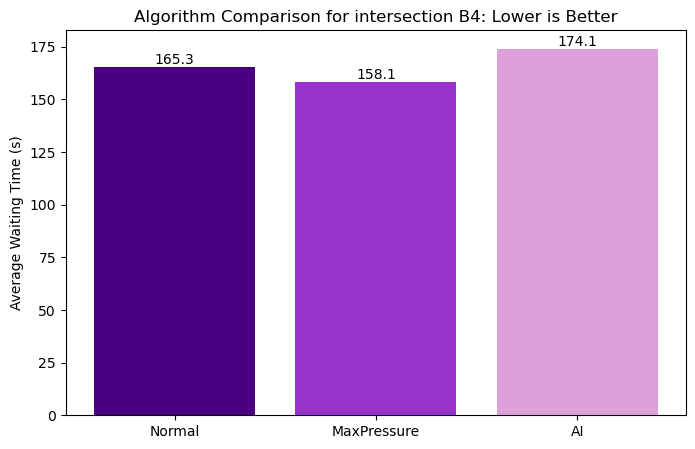

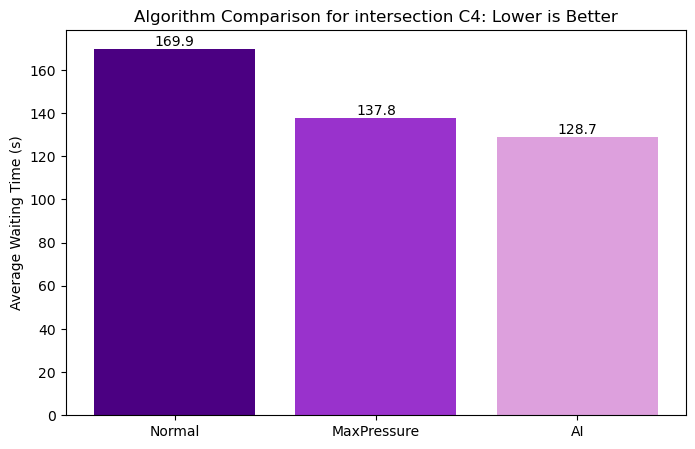

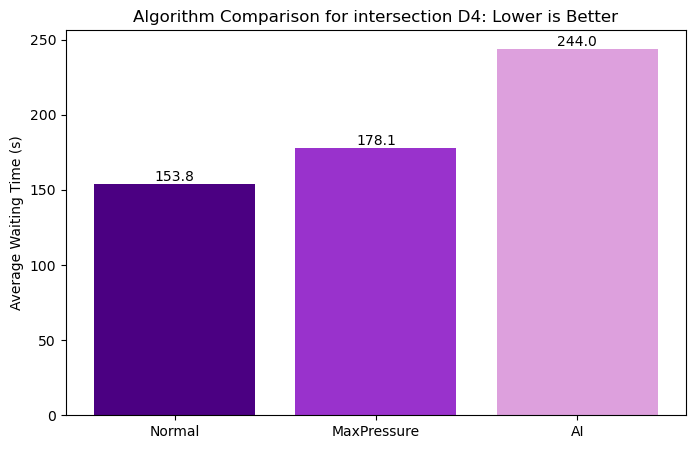

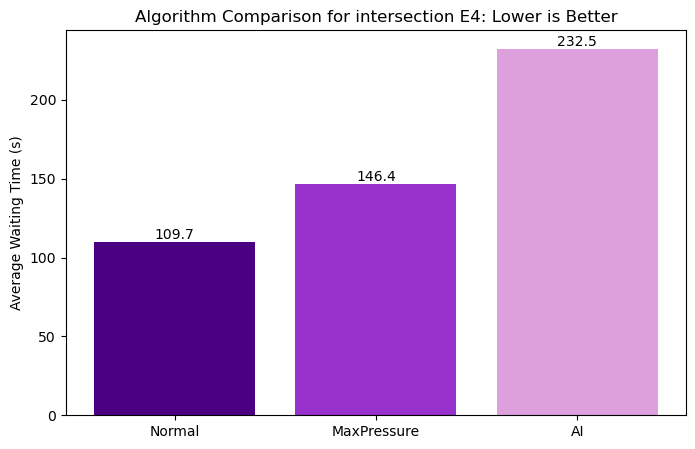

In [20]:
for lane_name, lane_list in lanes_to_plot.items():
    avg_wait_normal = average_waiting_time(df_normal[df_normal['departLane'].isin(lane_list)])
    avg_wait_maxpressure = average_waiting_time(df_maxpressure[df_maxpressure['departLane'].isin(lane_list)])
    avg_wait_ai = average_waiting_time(df_ai[df_ai['departLane'].isin(lane_list)])
    plt.figure(figsize=(8, 5))
    labels = ['Normal', 'MaxPressure', 'AI']
    values = [avg_wait_normal, avg_wait_maxpressure, avg_wait_ai]
    colors = ['indigo','darkorchid', 'plum']
    bars = plt.bar(labels, values, color=colors)
    plt.ylabel("Average Waiting Time (s)")
    plt.title(f"Algorithm Comparison for intersection {lane_name}: Lower is Better")
    plt.bar_label(bars, fmt='%.1f')
    plt.savefig(f"final_comparison_{lane_name}.png")
    plt.show()

## Travel time  

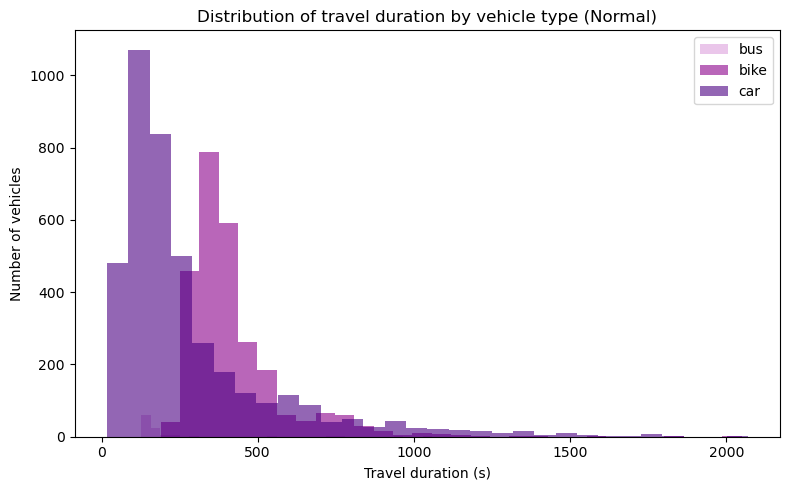

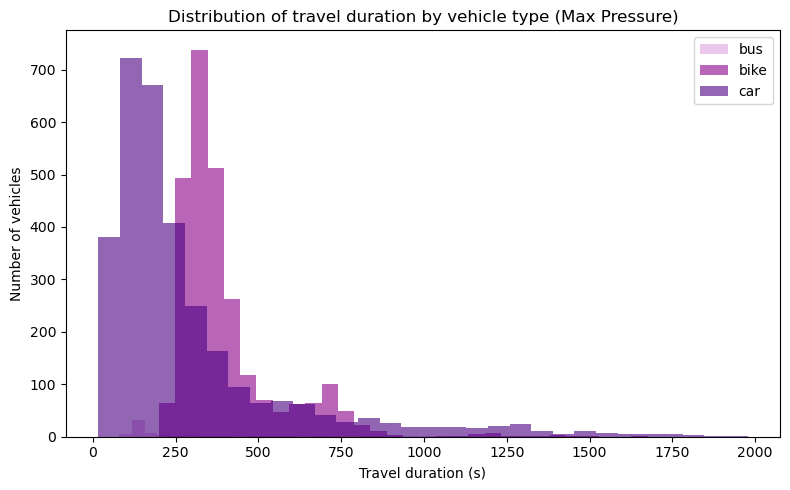

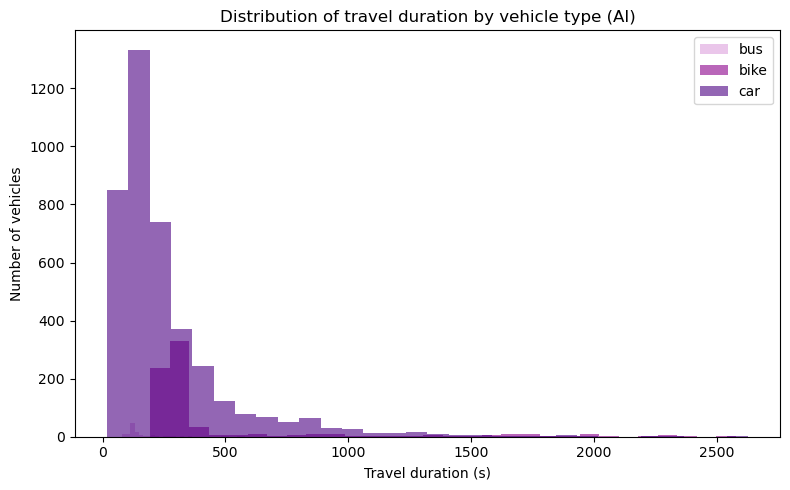

In [26]:
def plot_travel_time_distribution(df,mode):
    plt.figure(figsize=(8,5))

    color_map = {
        "car": "indigo",
        "bike": "darkmagenta",
        "bus": "plum"
    }
    for vtype in df['vType'].unique():
        subset = df[df['vType'] == vtype]
        plt.hist(
        subset['duration'],
        bins=30,
        alpha=0.6,
        label=vtype,
        color=color_map[vtype]
)
    plt.xlabel("Travel duration (s)")
    plt.ylabel("Number of vehicles")
    plt.title(f"Distribution of travel duration by vehicle type ({mode})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_travel_time_distribution(df_normal,"Normal")
plot_travel_time_distribution(df_maxpressure,"Max Pressure")
plot_travel_time_distribution(df_ai,"AI")

In [27]:
def average_travel_time(df):
    return df['duration'].mean()

avg_travel_normal = average_travel_time(df_normal)
avg_travel_maxpressure = average_travel_time(df_maxpressure)
avg_travel_ai = average_travel_time(df_ai)
print(f"Average Travel Time (AI): {avg_travel_ai:.2f} s")
print(f"Average Travel Time (Normal): {avg_travel_normal:.2f} s")
print(f"Average Travel Time (Max Pressure): {avg_travel_maxpressure:.2f} s")

Average Travel Time (AI): 293.20 s
Average Travel Time (Normal): 334.58 s
Average Travel Time (Max Pressure): 342.98 s


## Total time loss

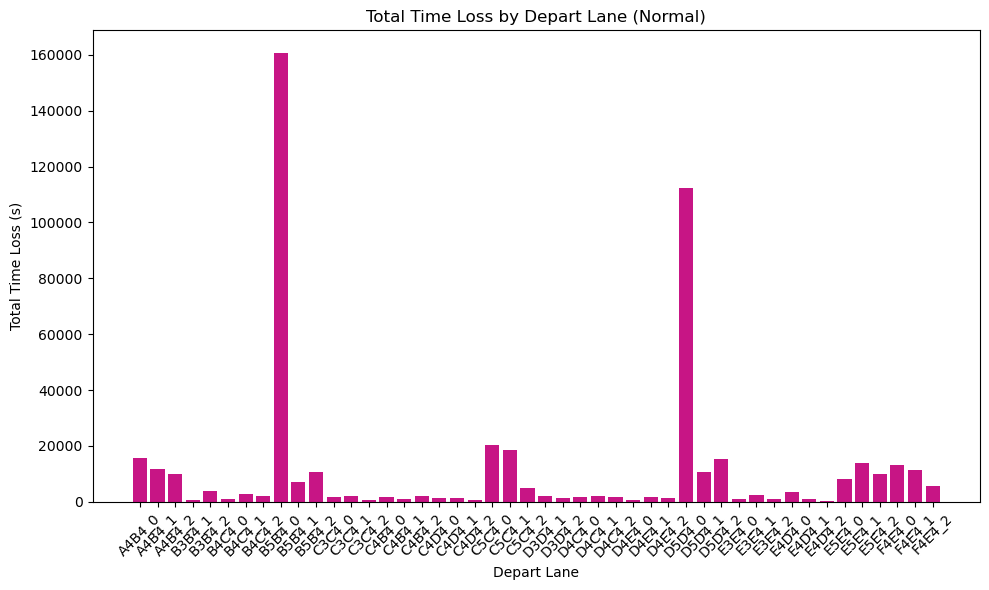

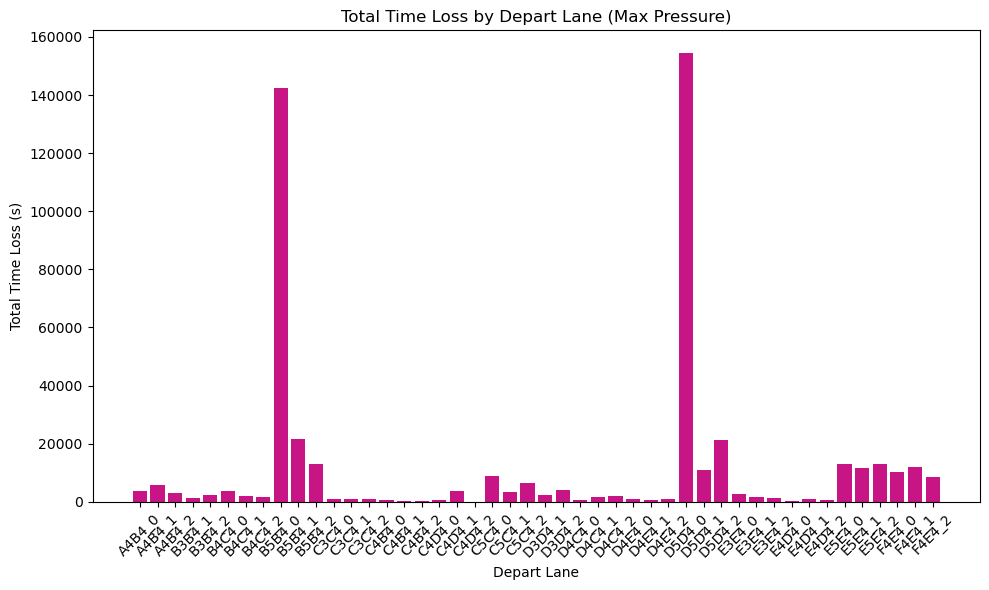

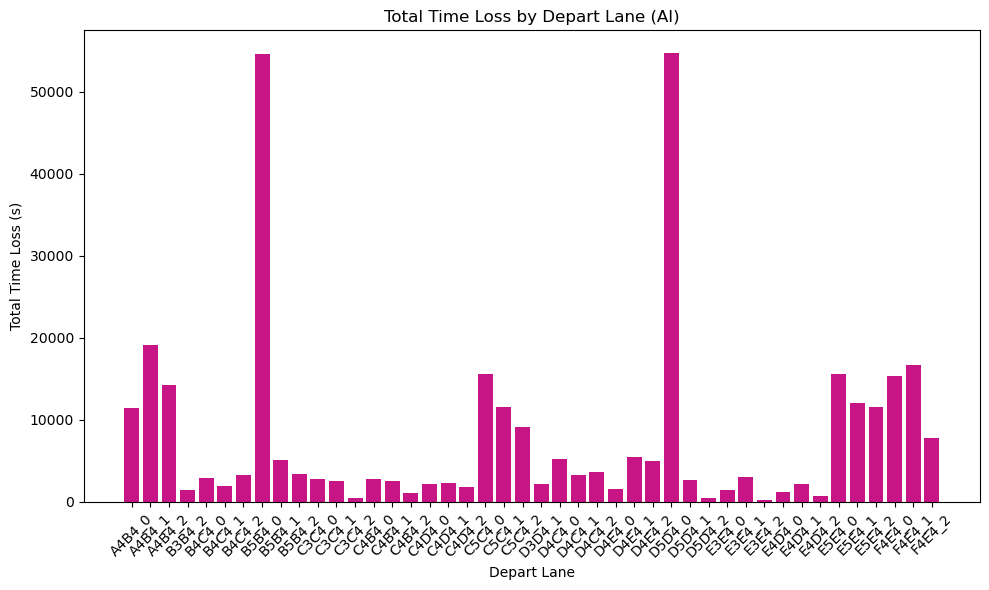

In [28]:
def plot_total_time_loss_by_lane(df, mode, lanes_to_plot):
    # Flatten all lane lists from the dict
    all_lanes = [lane for group in lanes_to_plot.values() for lane in group]

    lane_time_loss = df.groupby('departLane')['timeLoss'].sum().reset_index()
    lane_time_loss = lane_time_loss[lane_time_loss['departLane'].isin(all_lanes)]

    plt.figure(figsize=(10, 6))
    plt.bar(lane_time_loss['departLane'], lane_time_loss['timeLoss'], color = "mediumvioletred")
    plt.xlabel('Depart Lane')
    plt.ylabel('Total Time Loss (s)')
    plt.title(f'Total Time Loss by Depart Lane ({mode})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_total_time_loss_by_lane(df_normal, "Normal", lanes_to_plot)
plot_total_time_loss_by_lane(df_maxpressure, "Max Pressure", lanes_to_plot)
plot_total_time_loss_by_lane(df_ai, "AI", lanes_to_plot)

In [29]:
def total_time_loss(df):
    return df['timeLoss'].sum()

total_loss_normal = total_time_loss(df_normal)
total_loss_maxpressure = total_time_loss(df_maxpressure)
total_loss_ai = total_time_loss(df_ai)

print(f"Total Time Loss (AI): {total_loss_ai:.2f} s")
print(f"Total Time Loss (Normal): {total_loss_normal:.2f} s")
print(f"Total Time Loss (Max Pressure): {total_loss_maxpressure:.2f} s")

Total Time Loss (AI): 1017954.64 s
Total Time Loss (Normal): 1511216.24 s
Total Time Loss (Max Pressure): 1326782.40 s


## Queue length

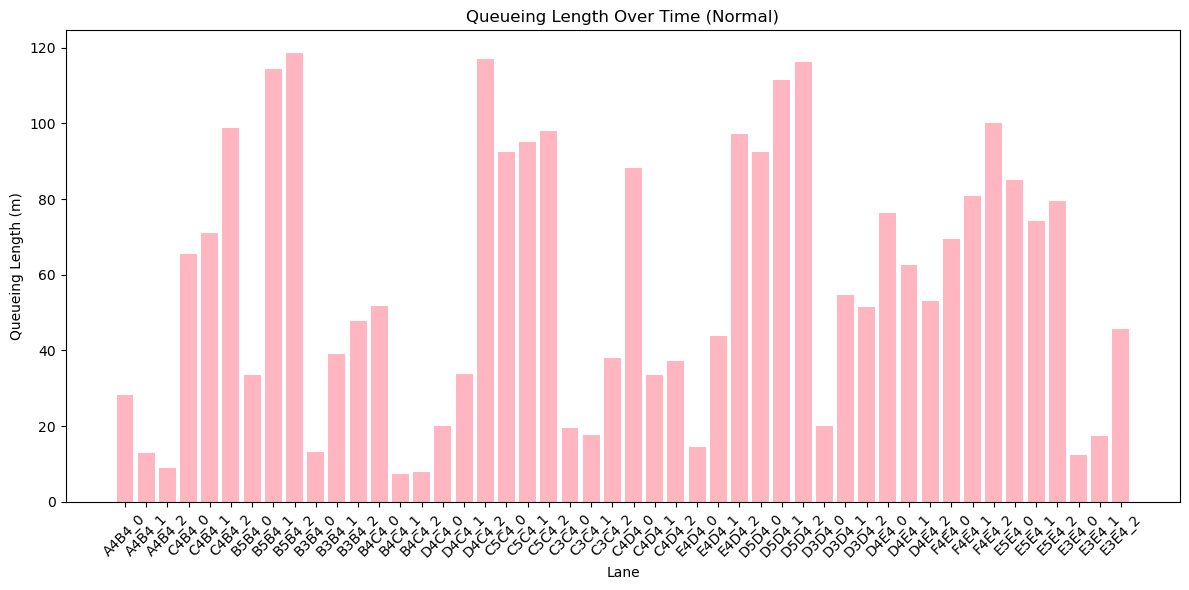

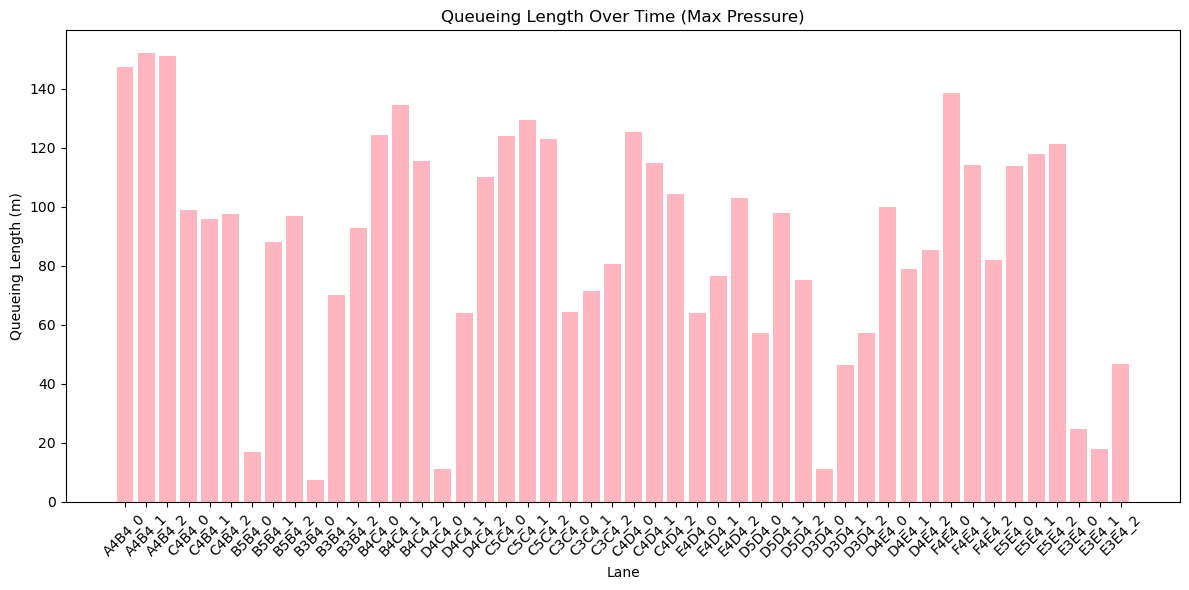

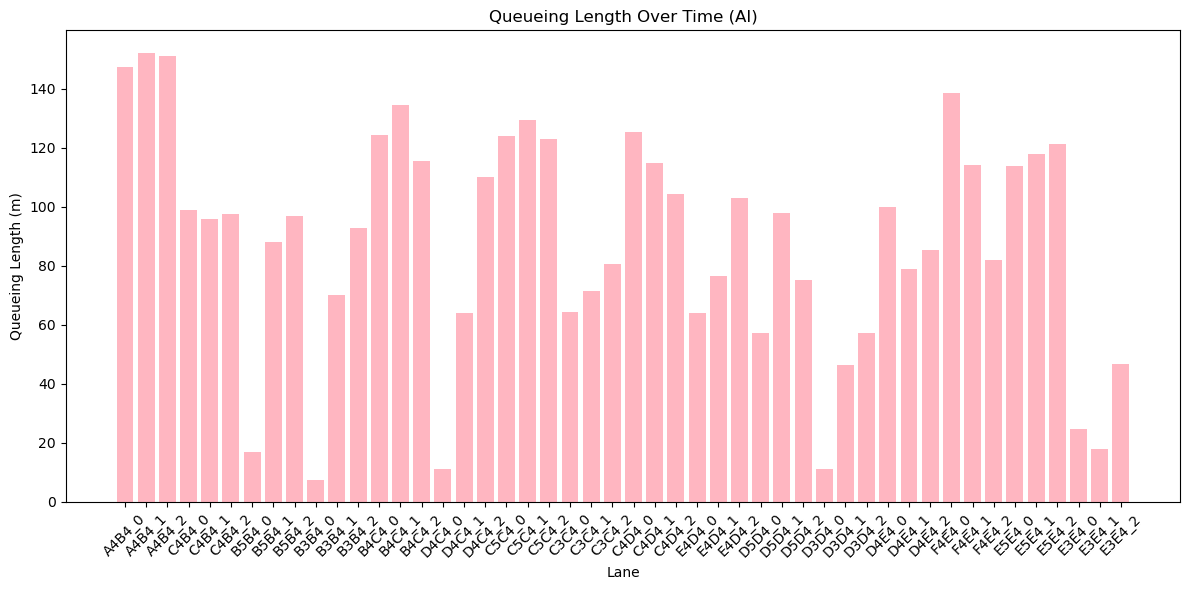

In [30]:
def plot_mean_queue_length(df_queue, lanes_to_plot, mode):
    plt.figure(figsize=(12, 6))

    # Flatten all lane lists from the dict
    all_lanes = [lane for group in lanes_to_plot.values() for lane in group]

    for lane in all_lanes:
        lane_data = df_queue[df_queue['lane_id'] == lane]

        if lane_data.empty:
            continue
        df_mean = lane_data.groupby('lane_id')['queueing_length'].mean()
        plt.bar(df_mean.index, df_mean.values, color = "lightpink" )


    plt.xlabel('Lane')
    plt.ylabel('Queueing Length (m)')
    plt.title(f'Queueing Length Over Time ({mode})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_mean_queue_length(
    df_queue_normal,
    lanes_to_plot,
    mode="Normal"
)


plot_mean_queue_length(
    df_queue_maxpressure, 
    lanes_to_plot,
    mode="Max Pressure"
    )


plot_mean_queue_length(
    df_queue_maxpressure, 
    lanes_to_plot,
    mode="AI"
    )

In [31]:
def mean_queue_length(df_queue, lanes_to_plot):
    # Flatten all lane lists from the dict
    all_lanes = [lane for group in lanes_to_plot.values() for lane in group]

    lane_mean_queue = df_queue[df_queue['lane_id'].isin(all_lanes)].groupby('lane_id')['queueing_length'].mean().reset_index()
    average_queue_length = lane_mean_queue['queueing_length'].mean()
    return average_queue_length

mean_queue_length_normal = mean_queue_length(df_queue_normal, lanes_to_plot)
mean_queue_length_maxpressure = mean_queue_length(df_queue_maxpressure, lanes_to_plot)
mean_queue_length_ai = mean_queue_length(df_queue_ai, lanes_to_plot)

print(f"Mean Queue Length (Normal): {mean_queue_length_normal:.2f} m")
print(f"Mean Queue Length (Max Pressure): {mean_queue_length_maxpressure:.2f} m")
print(f"Mean Queue Length (AI): {mean_queue_length_ai:.2f} m")

Mean Queue Length (Normal): 57.65 m
Mean Queue Length (Max Pressure): 88.38 m
Mean Queue Length (AI): 82.85 m


## Emissions

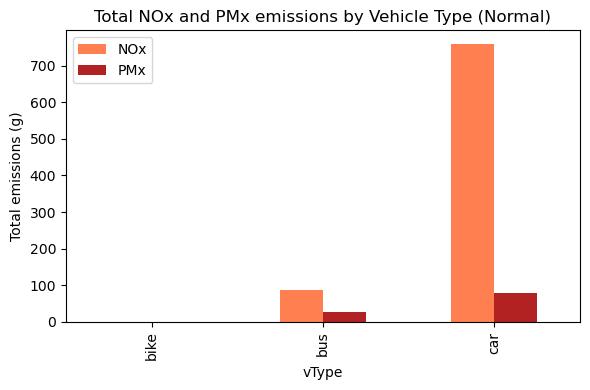

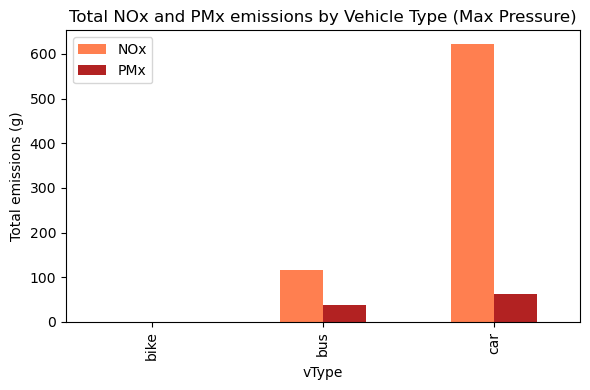

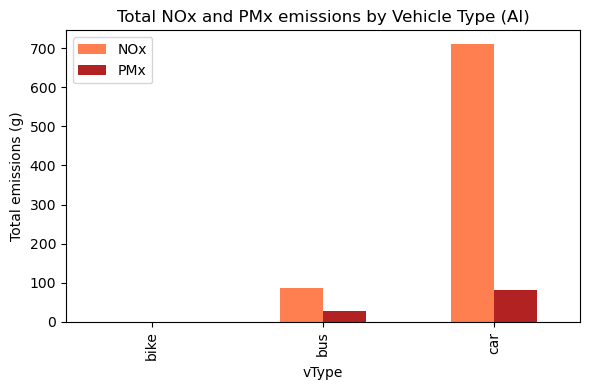

In [32]:
def plot_total_nox_and_pm_by_vtype(df, mode,title):
    nox_pmx = df.groupby("vType")[["NOx", "PMx"]].sum() / 1000  # mg → g
    ax = nox_pmx.plot(kind='bar', figsize=(6,4), color=['coral', 'firebrick'])
    ax.set_ylabel("Total emissions (g)")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_total_nox_and_pm_by_vtype(df_normal, "Normal", "Total NOx and PMx emissions by Vehicle Type (Normal)")
plot_total_nox_and_pm_by_vtype(df_maxpressure, "Max Pressure", "Total NOx and PMx emissions by Vehicle Type (Max Pressure)")
plot_total_nox_and_pm_by_vtype(df_ai, "AI", "Total NOx and PMx emissions by Vehicle Type (AI)")

In [33]:
passenger_counts = {
    "car": 1.5,  # average passengers per car
    "bus": 37    # average passengers per bus
}

df_normal['passenger_count'] = df_normal['vType'].map(passenger_counts).fillna(0)
df_maxpressure['passenger_count'] = df_maxpressure['vType'].map(passenger_counts).fillna(0)
df_ai['passenger_count'] = df_ai['vType'].map(passenger_counts).fillna(0)

In [42]:
def average_CO2_by_person(df, mode):
    df['CO2_per_person'] = df['CO2'] / df['passenger_count'] / 1000
    avg_CO2_per_person = df[df['vType'].isin(['car', 'bus'])].groupby('vType')['CO2_per_person'].mean()
    print(f"\nAverage CO2 emissions per person (g) for {mode}:")
    print(avg_CO2_per_person)
    
average_CO2_by_person(df_normal, "Normal")
average_CO2_by_person(df_maxpressure, "Max Pressure")
average_CO2_by_person(df_ai, "AI")


Average CO2 emissions per person (g) for Normal:
vType
bus     45.240040
car    339.035693
Name: CO2_per_person, dtype: float64

Average CO2 emissions per person (g) for Max Pressure:
vType
bus     58.705828
car    351.579650
Name: CO2_per_person, dtype: float64

Average CO2 emissions per person (g) for AI:
vType
bus     42.416236
car    318.119515
Name: CO2_per_person, dtype: float64


In [ ]:
def average_pmx_by_person(df, mode):
    df['PMX_per_person'] = df['PMx'] / df['passenger_count'] / 1000
    avg_pmx_per_person = df[df['vType'].isin(['car', 'bus'])].groupby('vType')['PMX_per_person'].mean()
    print(f"\nAverage PMx emissions per person (g) for {mode}:")
    print(avg_pmx_per_person)
    
average_pmx_by_person(df_normal, "Normal")
average_pmx_by_person(df_maxpressure, "Max Pressure")
average_pmx_by_person(df_ai, "AI")


Average PMx emissions per person (g) for Normal:
vType
bus    0.007511
car    0.012967
Name: PMX_per_person, dtype: float64

Average PMx emissions per person (g) for Max Pressure:
vType
bus    0.013224
car    0.012871
Name: PMX_per_person, dtype: float64

Average PMx emissions per person (g) for AI:
vType
bus    0.006467
car    0.013326
Name: PMX_per_person, dtype: float64


In [35]:
def average_nox_by_person(df, mode):
#moyenne d'emission par personne pour les voitures et les bus
    passenger_counts = {
        "car": 1.5,  # average passengers per car
        "bus": 37    # average passengers per bus
    }

    df['passenger_count'] = df['vType'].map(passenger_counts).fillna(0)
    df['NOX_per_person'] = df['NOx'] / df['passenger_count'] / 1000
    avg_nox_per_person = df[df['vType'].isin(['car', 'bus'])].groupby('vType')['NOX_per_person'].mean()
    print(f"\nAverage NOX emissions per person (g) for {mode}:")
    print(avg_nox_per_person)

average_nox_by_person(df_normal, "Normal")
average_nox_by_person(df_maxpressure, "Max Pressure")
average_nox_by_person(df_ai, "AI")


Average NOX emissions per person (g) for Normal:
vType
bus    0.023436
car    0.124844
Name: NOX_per_person, dtype: float64

Average NOX emissions per person (g) for Max Pressure:
vType
bus    0.040137
car    0.130085
Name: NOX_per_person, dtype: float64

Average NOX emissions per person (g) for AI:
vType
bus    0.020362
car    0.116399
Name: NOX_per_person, dtype: float64


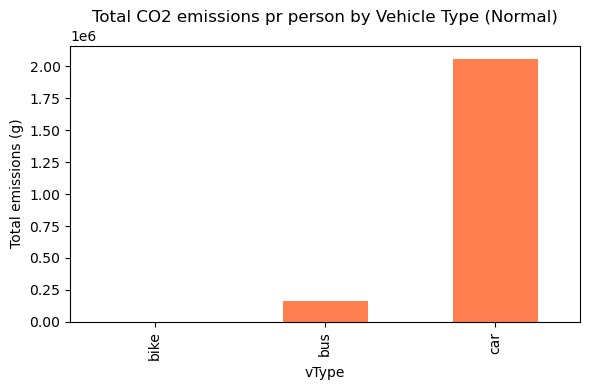

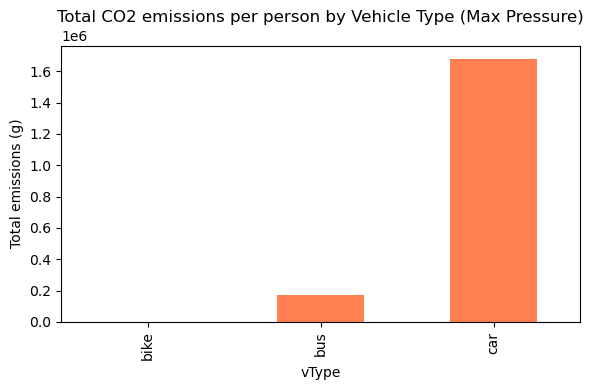

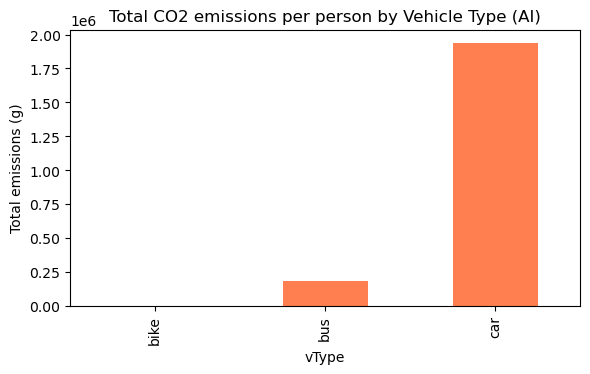

In [41]:
def plot_total_CO2_by_vtype(df, mode,title):
    nox_pmx = df.groupby("vType")["CO2"].sum() / 1000  # mg → g
    ax = nox_pmx.plot(kind='bar', figsize=(6,4), color='coral')
    ax.set_ylabel("Total emissions (g)")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_total_CO2_by_vtype(df_normal, "Normal", "Total CO2 emissions pr person by Vehicle Type (Normal)")
plot_total_CO2_by_vtype(df_maxpressure, "Max Pressure", "Total CO2 emissions per person by Vehicle Type (Max Pressure)")
plot_total_CO2_by_vtype(df_ai, "AI", "Total CO2 emissions per person by Vehicle Type (AI)")

In [37]:
def average_co2_by_person(df, mode):
#moyenne d'emission par personne pour les voitures et les bus
    passenger_counts = {
        "car": 1.5,  # average passengers per car
        "bus": 37    # average passengers per bus
    }

    df['passenger_count'] = df['vType'].map(passenger_counts).fillna(0)
    df['CO2_per_person'] = df['CO2'] / df['passenger_count'] / 1000
    avg_co2_per_person = df[df['vType'].isin(['car', 'bus'])].groupby('vType')['CO2_per_person'].mean()
    print(f"\nAverage CO2 emissions per person (g) for {mode}:")
    print(avg_co2_per_person)
    
average_co2_by_person(df_normal, "Normal")
average_co2_by_person(df_maxpressure, "Max Pressure")
average_co2_by_person(df_ai, "AI")


Average CO2 emissions per person (g) for Normal:
vType
bus     45.240040
car    339.035693
Name: CO2_per_person, dtype: float64

Average CO2 emissions per person (g) for Max Pressure:
vType
bus     58.705828
car    351.579650
Name: CO2_per_person, dtype: float64

Average CO2 emissions per person (g) for AI:
vType
bus     42.416236
car    318.119515
Name: CO2_per_person, dtype: float64


## Final table KPIs

In [38]:
def table_kpis():
    kpis = {
        "Mode": ["Normal", "Max Pressure","AI"],
        "Avg Waiting Time (s)": [
            average_waiting_time(df_normal),
            average_waiting_time(df_maxpressure),
            average_waiting_time(df_ai)
        ],
        "Total Time Loss (s)": [
            total_time_loss(df_normal),
            total_time_loss(df_maxpressure),
            total_time_loss(df_ai)
        ],
        "Avg Travel Time (s)": [
            average_travel_time(df_normal),
            average_travel_time(df_maxpressure),
            average_travel_time(df_ai)
        ],
        "Mean Queue Length (m)": [
            mean_queue_length(df_queue_normal, lanes_to_plot),
            mean_queue_length(df_queue_maxpressure, lanes_to_plot),
            mean_queue_length(df_queue_ai, lanes_to_plot)
        ],
        "Total Emissions NOx (g)": [
            df_normal['NOx'].sum() / 1000,
            df_maxpressure['NOx'].sum() / 1000,
            df_ai['NOx'].sum() / 1000
        ],
        "Total Emissions PMx (g)": [
            df_normal['PMx'].sum() / 1000,
            df_maxpressure['PMx'].sum() / 1000,
            df_ai['PMx'].sum() / 1000
        ],
        "Total Emissions CO2 (g)": [
            df_normal['CO2'].sum() / 1000,
            df_maxpressure['CO2'].sum() / 1000,
            df_ai['CO2'].sum() / 1000
        ]
    }

    df = pd.DataFrame(kpis)

    # Round all numeric columns
    df = df.round(2)

# Style the table
    styled = (
        df.style
        .set_caption("KPI Summary Table")
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "18px"), ("font-weight", "bold")]}
        ])
        .background_gradient(cmap="RdPu", subset=df.columns[1:])
        .hide(axis="index")
    )


    return styled

table_kpis()


Mode,Avg Waiting Time (s),Total Time Loss (s),Avg Travel Time (s),Mean Queue Length (m),Total Emissions NOx (g),Total Emissions PMx (g),Total Emissions CO2 (g)
Normal,165.700000,1511216.240000,334.580000,57.650000,844.270000,106.280000,2225356.100000
Max Pressure,168.450000,1326782.400000,342.980000,88.380000,737.700000,99.690000,1850151.540000
AI,157.970000,1017954.640000,293.200000,82.850000,797.310000,109.030000,2122261.410000
